In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame, TwitterSearchTerm
import utils as ut

In [2]:
# Get the health data from 2018 and agreggate.
# Note -- this is in the mendocino directory, but it
# is more than just mendocino data, too.
health_files = os.listdir('../data/mendocino/data')
health_dfs = []
for f in health_files:
    health_dfs.append(pd.read_csv('../data/mendocino/data/'+f))
    
health_df = pd.concat(health_dfs)

In [3]:
# Turn into a TwitterDataFrame and zoom in on san francisco
health_df = TwitterDataFrame(health_df)
lat = (37, 39)
lon = (-121, -124)
sf_df = health_df.zoom_in(lat, lon)

In [4]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  7862
Per day : 21.53972602739726


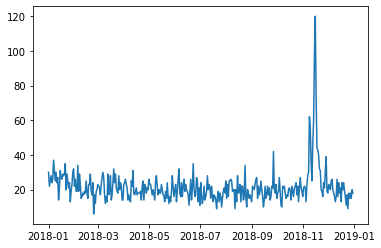

In [7]:
sf_df['created_at'] = [datetime.strptime(d,'%Y-%m-%dT%H:%M:%S.%fZ') for d in sf_df['created_at']]

plt.plot(sf_df.count_by_day())

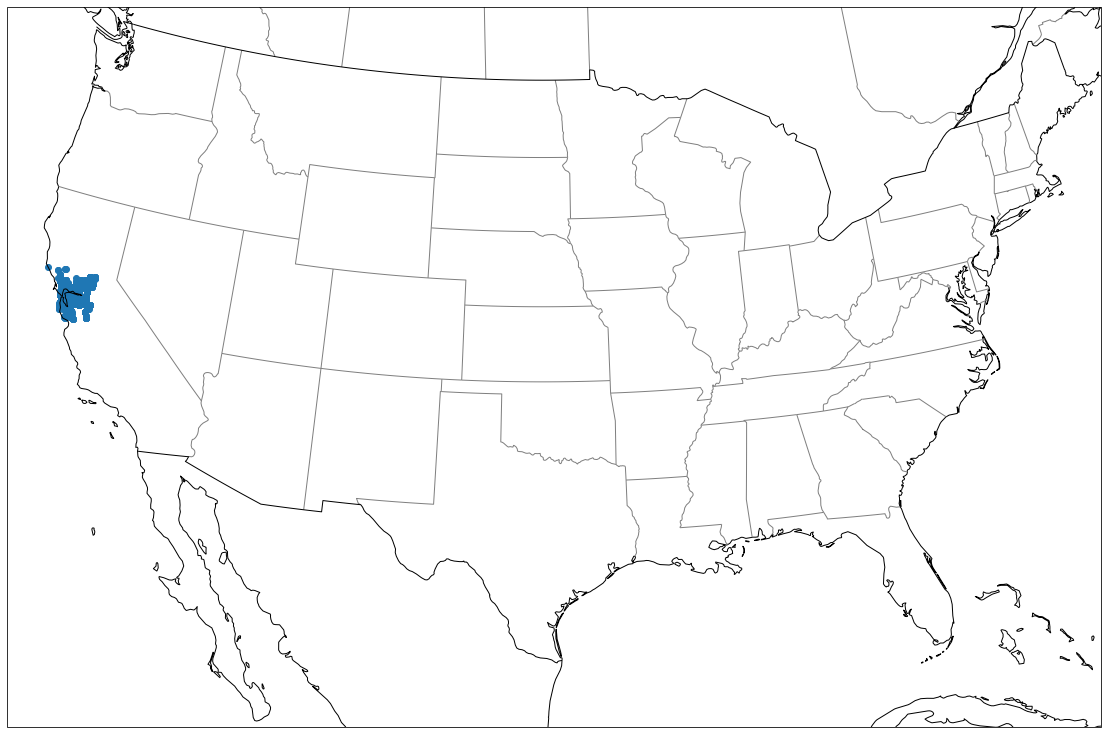

In [23]:
import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(sf_df['lon'],sf_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

# Let's turn our attention to looking at the topics, now

In [24]:
from nltk.tokenize import TweetTokenizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import re

In [26]:
cleaned_tweets = []
lemmatizer = WordNetLemmatizer()
tt = TweetTokenizer()
stopword_list = nltk.corpus.stopwords.words("english")
health_tweets = sf_df['text']
for tweet in health_tweets:
    t = tweet.lower()
#     t = remove_special_characters(t)
    t = tt.tokenize(t)
    t = [w for w in t if w.isalpha()]
    t = [lemmatizer.lemmatize(w) for w in t]
#     t = [w for w in t if w not in words_to_remove]
    cleaned_tweets.append(t)
# This is so we can pass this value into the count vectorizer
ct = [" ".join(t) for t in cleaned_tweets]

In [27]:
# Let's see how we can extract feature counts
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_df=.9, min_df=10)
termFrequency = cv.fit_transform(ct)
feature_names = cv.get_feature_names_out()

In [37]:
from sklearn.decomposition import LatentDirichletAllocation
n_components = 10
lda = LatentDirichletAllocation(max_iter=50, n_components=n_components, random_state=42)

topic_assignment = lda.fit_transform(termFrequency)

In [38]:
for idx, topic in enumerate(lda.components_):
    print("Topic", idx," ".join(feature_names[i] for i in np.argsort(topic)[-20:]))

Topic 0 doe send huddled face thank yearning sure mass make door lung yes sing free able water poor help tired breathe
Topic 1 hour ago real went felt didn couldn good day tonight got year finally week time im today like breathe wa
Topic 2 really play watch barely stop girl game need trying want fucking right literally giving hard time lol let just breathe
Topic 3 drinking gotta wtf starting fattest love massive coffee drink morning gave big night need just woke bad remember got headache
Topic 4 ha time asthma fever head lung feeling better cold bad eye just nose hurt smoke sick sore throat like feel
Topic 5 thing work know money ha new got better good use buy like nice class cold medicine syrup need drop cough
Topic 6 home scream friend asthma did old mouth said wa song kid screaming singing think like just people don know lung
Topic 7 window talking baby people outside work god make asthma want oh crazy doing thing man getting fat lung fuck headache
Topic 8 love make world smoke lung

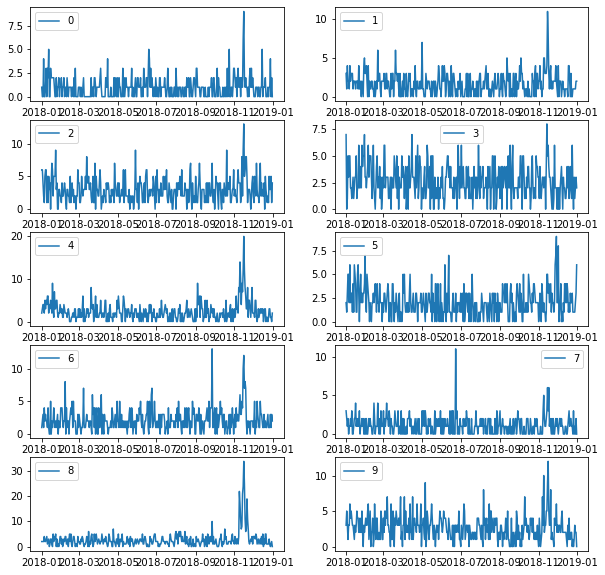

In [39]:
# Let's look at these topics over time
topics = np.argmax(topic_assignment, axis=1)
sf_df['topic'] = topics
topic_by_date = pd.pivot_table(sf_df, values="id",index='date',columns='topic', aggfunc='count',fill_value=0)
tbd = topic_by_date.reset_index()
# plt.subplots(2, 5)
plt.figure(figsize=(10,10))
for i in range(0,10):
    plt.subplot(5,2, i+1)
    plt.plot(tbd['date'],tbd[i], label=i)
    plt.legend()

In [40]:
print("Perplexity: ", lda.bound_)
print("Iterations: ",lda.n_batch_iter_)

Perplexity:  484.4484114435733
Iterations:  51


# Improving the topics using "pseudo-documents"

In [26]:
# Combine the documents
pseudo_docs = pd.pivot_table(sf_df,values="text",index="date",aggfunc=" ".join)
docs = pseudo_docs['text']

In [27]:
from nltk.tokenize import TweetTokenizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import re

In [30]:
cleaned_tweets = []
lemmatizer = WordNetLemmatizer()
tt = TweetTokenizer()
stopword_list = nltk.corpus.stopwords.words("english")

for d in docs:
    t = d.lower()
#     t = remove_special_characters(t)
    t = tt.tokenize(t)
    t = [w for w in t if w.isalpha()]
    t = [lemmatizer.lemmatize(w) for w in t]
    t = [w for w in t if w not in stopword_list]
    cleaned_tweets.append(t)
# This is so we can pass this value into the count vectorizer
ct = [" ".join(t) for t in cleaned_tweets]

In [131]:
# Let's see how we can extract feature counts
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(stop_words='english', max_df=.9, min_df=5)
tf = TfidfVectorizer(stop_words='english', max_df=.95, min_df=5)
termFrequency = cv.fit_transform(ct)
feature_names = cv.get_feature_names_out()
tfTermFreq = tf.fit_transform(ct)
tf_feature_names = tf.get_feature_names_out()

In [138]:
from sklearn.decomposition import LatentDirichletAllocation
n_components = 10
lda = LatentDirichletAllocation(max_iter=1000, n_components=n_components, random_state=42)

topic_assignment = lda.fit_transform(tfTermFreq)

In [139]:
# Perplexity
print(lda.bound_)
print(lda.n_iter_)

5961.343933616179
1000


In [134]:
lda.components_.shape

(10, 1806)

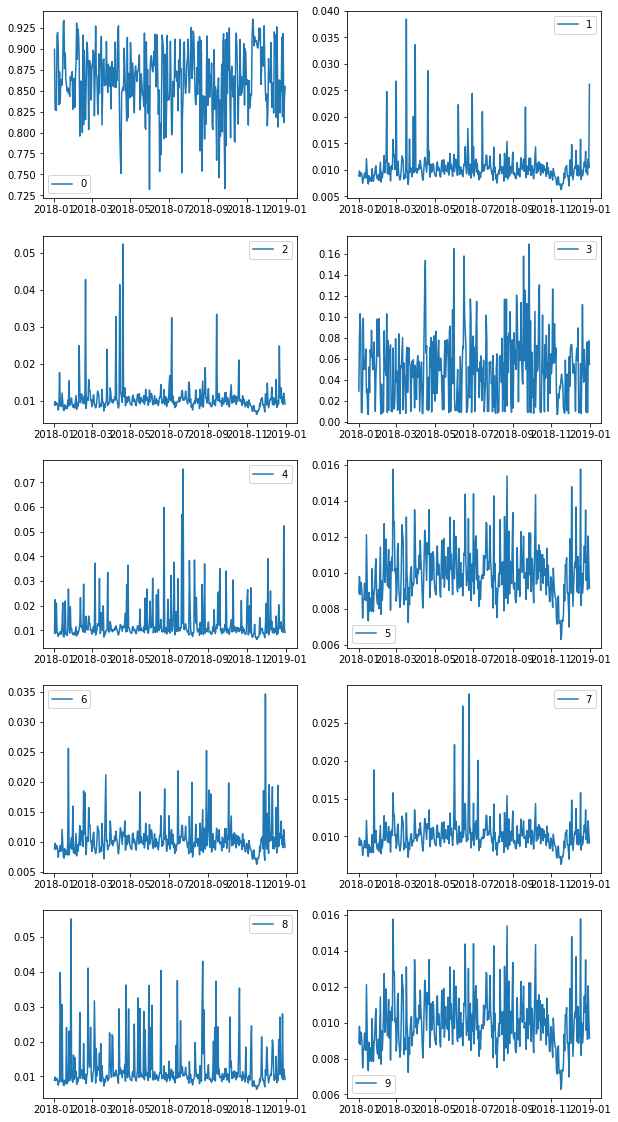

In [140]:
fig = plt.figure(figsize=(10,20))
for i in range(10):
    plt.subplot(5,2, i+1)
    plt.plot(pseudo_docs.index, topic_assignment.T[i], label=i)
    plt.legend()

In [141]:
for idx, topic in enumerate(lda.components_):
    print("Topic", idx," ".join(tf_feature_names[i] for i in np.argsort(topic)[:-20 - 1 : -1]))

Topic 0 cough lung like wa day got time throat feel need asthma air sore know today remember people bad ha really
Topic 1 cried fruit devil candidate proceeded date floor politics park artist staring scene ended fish donut closing diagnosed recommend punch oops
Topic 2 pant fastest randomly devil goal cologne lecture anxious parking pair society sweat curious tonsil present bf jones demi chew packed
Topic 3 laughing pas step apple american infection si soul looked bigger awake ended loving flight mild asked center yelled floor tear
Topic 4 politics hahahaha quit ruin action color mucus daddy restroom bob cologne democrat text ray led torture permanent candidate policy scene
Topic 5 ray candidate scene torture text cologne randomly democrat gasp color fastest permanent hanging resident restroom action fruit cried led forward
Topic 6 scene text candidate tonsil color gasp cried step permanent quit wedding ray promise convinced dawg politics failure fully policy fail
Topic 7 ray text dawg

In [73]:
sf_df['text']

,id,text,geo,created_at,lat,lon,date
20,1013200041475911680,This shit gave me a headache,{'place_id': '66ec48e552bb105b'},2018-06-30 23:18:08,37.717441,-121.151704,2018-06-30
160,1013126837923340288,"@damanr Naw, let those tweets breathe. Lebron ...",{'place_id': 'ab2f2fac83aa388d'},2018-06-30 18:27:15,37.699279,-122.342660,2018-06-30
170,1013121651330899968,Thank god I woke up with no headache,{'place_id': '45cadd6ef118ec9f'},2018-06-30 18:06:39,37.330068,-122.065206,2018-06-30
189,1013111977382559745,@D1ZZLE_ 😂😂😂 fuck lungs,{'place_id': '3ad0f706b3fa62a8'},2018-06-30 17:28:12,37.362824,-122.190523,2018-06-30
219,1013093920505335808,Need to get rid of this headache b4 the match ...,{'place_id': '8af346f16e955392'},2018-06-30 16:16:27,37.561380,-122.096971,2018-06-30
...,...,...,...,...,...,...,...
17052,1024502925173784576,@poissantmakayla Try to get a room with a jacu...,{'place_id': 'e41805d7248dbf1e'},2018-08-01 03:51:46,37.594850,-121.074342,2018-08-01
17066,1024495616628387840,i have had extensive amounts of experiences (g...,{'place_id': 'a35b62af9d82aa08'},2018-08-01 03:22:43,37.842368,-122.100030,2018-08-01
17084,1024489256541020160,Just played almost 2 hours of basketball... wi...,{'place_id': 'e41805d7248dbf1e'},2018-08-01 02:57:27,37.594850,-121.074342,2018-08-01
17086,1024488976915161088,@BretGrimes This gave me a headache.,{'place_id': '5a110d312052166f'},2018-08-01 02:56:20,37.708075,-122.514926,2018-08-01


In [142]:
# is it possible that these results can create a linear model with AQI?
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')
ca_aqi = aqi_2018[aqi_2018['State Name']=="California"]


In [164]:
topic_assignment.shape

(365, 10)

In [145]:
sf_aqi = ca_aqi[ca_aqi['county Name']== 'San Francisco']

In [192]:
d_di = docs.reset_index()

In [193]:
for i, data in enumerate(topic_assignment.T):
    d_di[i] = data

In [220]:
aqi_by_date = []
for d in d_di['date']:
     aqi_by_date.append(sf_aqi.loc[str(d)]['AQI'])
        
d_di['aqi'] = aqi_by_date

In [222]:
x = d_di.drop(columns=['date','text', 'aqi'])
y = d_di['aqi']

In [224]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x,y)
lr.score(x,y)

0.10167632451947872

In [225]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size=0.22, random_state=42)

In [234]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=10)
model.fit(x_train, y_train)

model.predict(x_test)

array([40.1, 38.6, 83. , 52.8, 36.2, 43.3, 31.9, 39.9, 38.1, 40.7, 35.6,
       37.3, 40.8, 38.2, 32. , 52.8, 89. , 34.2, 35.5, 67.8, 40.5, 34.4,
       34.3, 40.1, 35.9, 42.5, 42. , 42.4, 42. , 39.9, 38.3, 39.6, 28.4,
       33.7, 33.6, 39.1, 43.6, 40.5, 36.6, 67.8, 37.1, 39.9, 39.1, 33.6,
       35.3, 38. , 32.1, 38.6, 39.3, 42. , 35.2, 56.1, 43. , 41. , 40.1,
       37.9, 30.5, 49.6, 42.5, 41.9, 32.6, 51.1, 38.4, 39.3, 37.5, 32.5,
       35.1, 31.2, 38.6, 43.3, 32.9, 39.1, 48.6, 41.4, 38.9, 37.6, 40.1,
       39.3, 40.8, 39.5, 41.8])

In [235]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, model.predict(x_test))

338.6175308641976

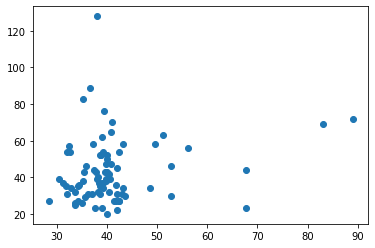

In [236]:
plt.scatter(model.predict(x_test), y_test)

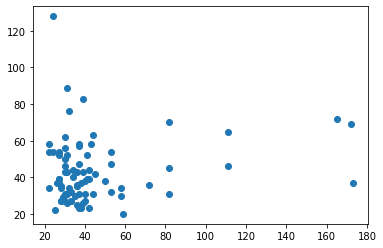

In [237]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
plt.scatter(clf.predict(x_test), y_test)

Darn -- doesn't look like the topics I learned really tell much of a story at all. Think I need to get more data and see if we can truly discover latent topics in San Francisco that tell a good story. Also, I need to look more into how to combine tweets.

Tonight:
* Work on getting organized. There is a lot you want/need to learn, so figure out how to organize this better! Perhaps it would be useful to review your notes.

# Todo:
* Work on making your results more interpretable.
* Look at fine-tuning this model. How can we get results that make sense, and how can I find the optimal number of topics in this case? What papers are out there that review measuring topic modeling?
* Work on deeply understanding the generative process for topic modeling.
* Continue reading literature on how topic modeling has advanced in the past decade.